In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [3]:
from matplotlib.colors import ListedColormap

In [4]:
#df = pd.read_excel('pack_benchmark_spec_v1.038.xlsx','Benchmarks',header=[0,1])
df = pd.read_excel('pack_benchmark_spec_v1.055.xlsm','Benchmarks',header=[0,1],skiprows=1,nrows=1055)

We will use _features_ for design (i.e. independent) variables and _metrics_ for the resulting, measurable (i.e. dependent variables) that describe the battery packs. \
This is one example of a set of features:

In [5]:
feature_set_0 = [('Cell',ft) for ft in ['Chemistry','Format','Capacity Ah','Nom V','mass kg']] + [('Configuration',ft) for ft in ['s','p']]

The spreadsheet has multicolumns, so we'll use a simple loop to find column names with an unlabeled second level. 

In [6]:
for soc_multicol_name in df.columns: 
    if 'SoC Window' in soc_multicol_name:
        break

In [7]:
for prod_multicol_name in df.columns: 
    if 'First produced' in prod_multicol_name:
        break

We will define a custom colourmap for cell chemistry. This way we can group similar cell chemistries by colour.

In [22]:
print(df.loc[:,('Cell','Chemistry')].astype('category').cat.categories)
print(len(df.loc[:,('Cell','Chemistry')].astype('category').cat.categories))

Index(['LFP', 'LMO', 'LTO', 'NCA', 'NCMA', 'NMC', 'NMC111', 'NMC523', 'NMC622',
       'NMC712', 'NMC811', 'NMC955', 'Na', 'NiCd', 'NiMh', 'PbA'],
      dtype='object')
16


In [9]:
cell_chem_cmap = ListedColormap(['lightgray','steelblue','cyan','limegreen','blue','blueviolet','coral','pink','darksalmon','indianred','crimson','firebrick','maroon','black','gold','yellow','dimgray'],N=17)
cell_chem_cmap.set_bad('lightgray')

# Trend analysis
Plotting different metrics against date of production. 

In [23]:
metric_set = [prod_multicol_name,
                soc_multicol_name,
                ('Gravimetric Energy Density','Wh/kg'),
                ('Volumetric Energy Density','Wh/litre'),
                ('Gravimetric Power Density','W10s/kg'),
                ('Cell to Pack Ratio','%')
                ]

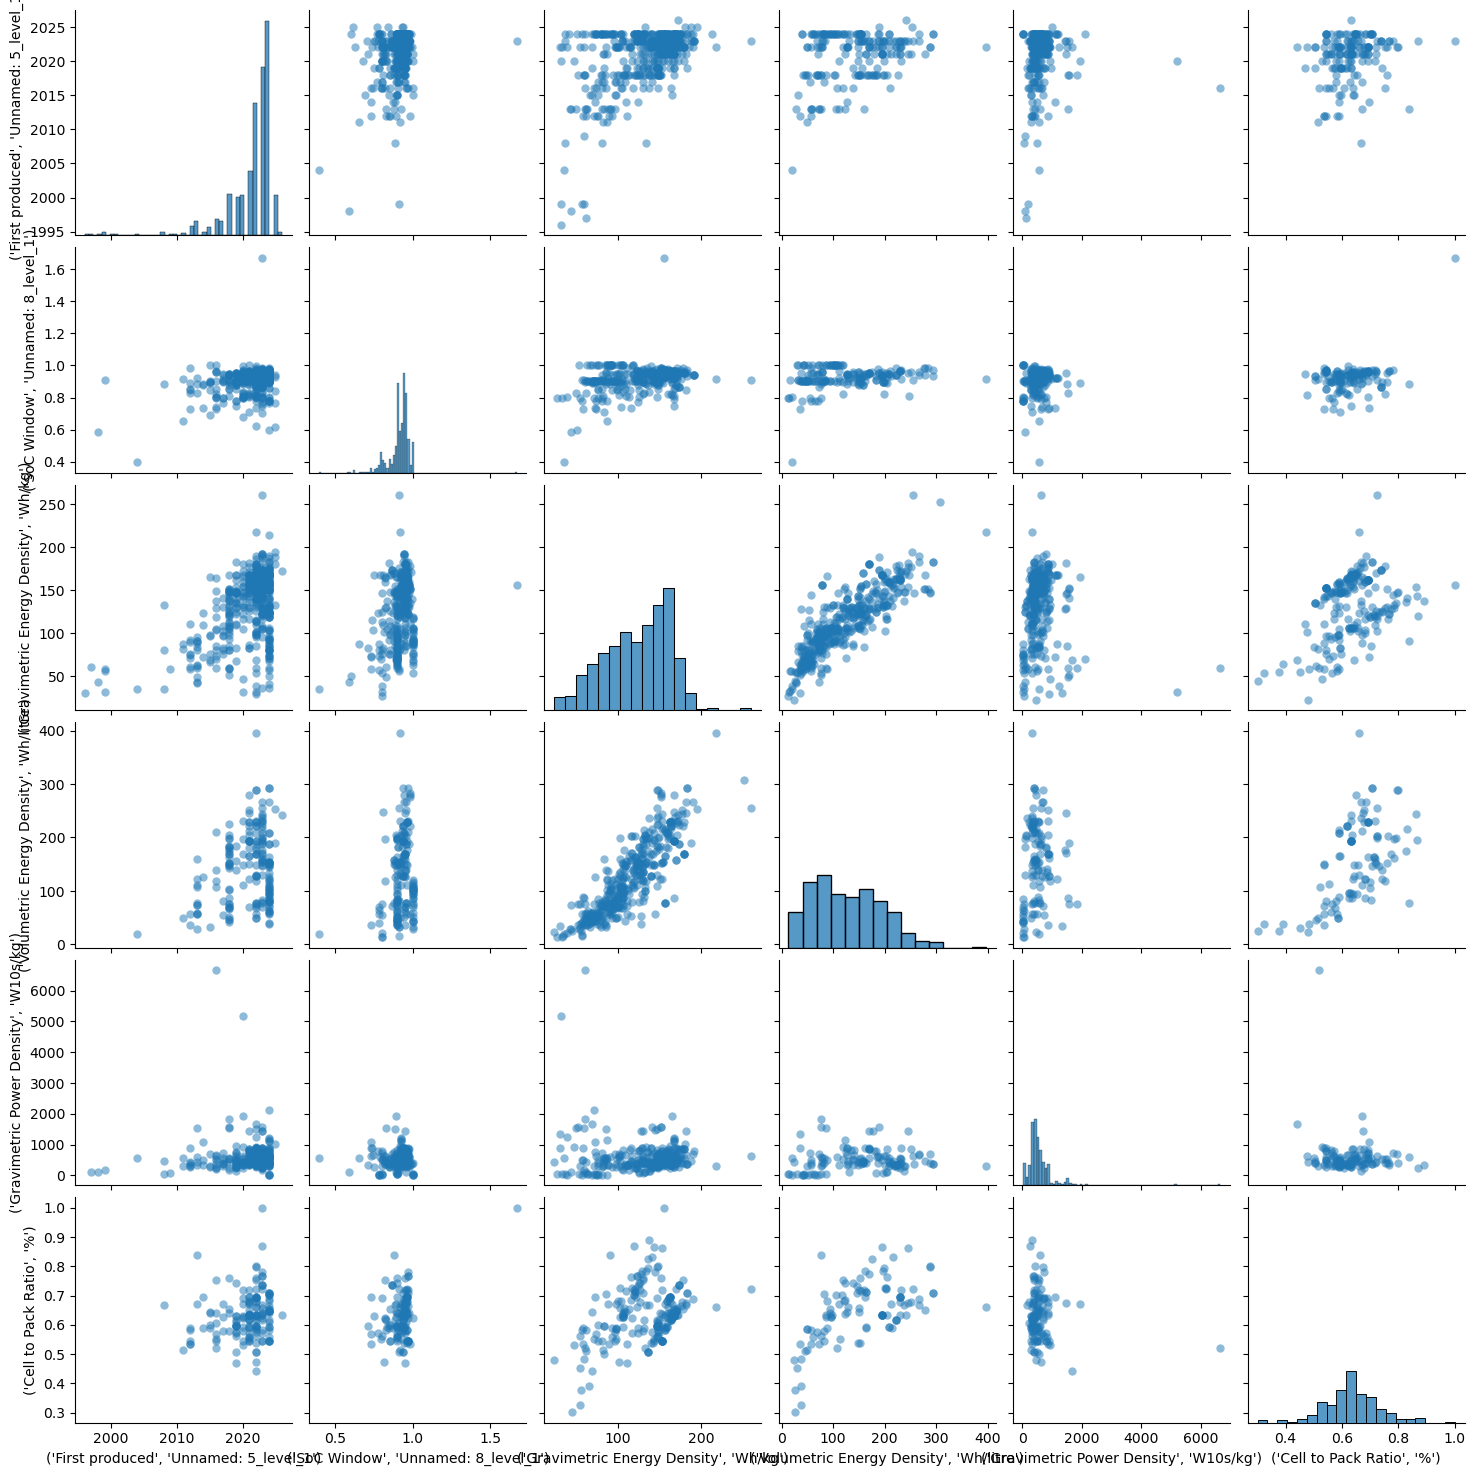

In [24]:
sns.pairplot(df.loc[:,metric_set],diag_kind='hist',plot_kws={'alpha':0.5,'linewidth':0.0})

Now we will plot some of these interesting trends with separate symbols and colours for cell format and cell chemistry. 

In [25]:
dependent_v = ('Gravimetric Energy Density','Wh/kg')

In [26]:
df_subset = df.loc[:,[prod_multicol_name,dependent_v]].dropna(axis=0)
subset_index = df_subset.index
X = df_subset.loc[:,prod_multicol_name].values.reshape(-1, 1)
y = df_subset.loc[:,dependent_v].values

In [21]:
cell_format_shape = ['x','+','^','o','s','p','v']

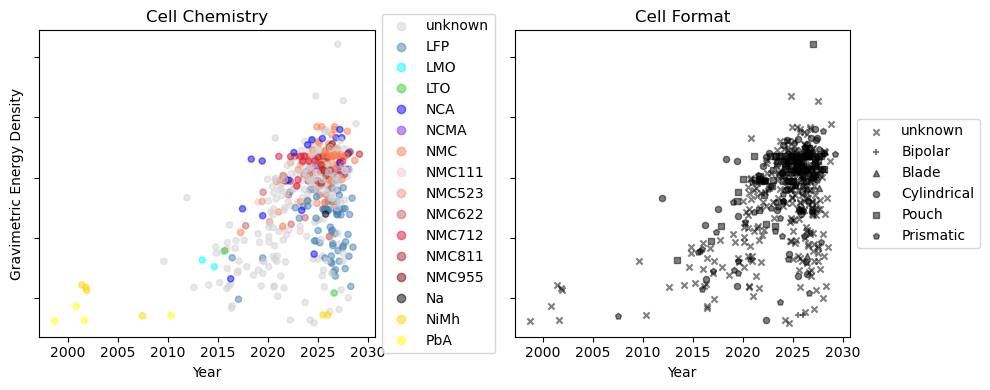

In [ ]:
fig,axs=plt.subplots(ncols=2,figsize=(10,4),sharey=True)
# Add random jitter to X in order to separate out values on the 'year' axis and make the plot clearer.  
X += np.random.random(X.shape)
# 1st plot: different colors
ax = axs[0]
scttr_0 = ax.scatter(X,y,
            s=20.0,
            c=df.loc[subset_index,('Cell','Chemistry')].astype('category').cat.codes,cmap=cell_chem_cmap,
            alpha=0.5,
            zorder=100,
            vmin=-1,
            vmax=cell_chem_cmap.N-1,
            )
handles_0,labels_0=scttr_0.legend_elements(num=None)

ax.set_xlabel('Year')
ax.set_ylabel(dependent_v[0])
ax.legend(handles_0,np.concat((['unknown'],df.loc[subset_index,('Cell','Chemistry')].astype('category').cat.categories.values)),
           loc='center left', bbox_to_anchor=(1.0,0.5))
ax.set_title('Cell Chemistry')
# 2nd plot: different shapes
ax = axs[1]
cell_format_labels = np.concat((['unknown'],df.loc[subset_index,('Cell','Format')].astype('category').cat.categories.values))
# have to loop
for k in range(*df.loc[subset_index,('Cell','Format')].unique().shape):
    X_k = X[df.loc[subset_index,('Cell','Format')].astype('category').cat.codes == k-1]
    y_k = y[df.loc[subset_index,('Cell','Format')].astype('category').cat.codes == k-1]
    scttr = ax.scatter(X_k,y_k,
                s=20.0,
                c='k',
                marker=cell_format_shape[k],
                alpha=0.5,
                zorder=k*20,
                label = cell_format_labels[k]
                )
ax.set_xlabel('Year')
leg = ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
handles_1 = leg.legend_handles
ax.set_title('Cell Format')

fig.tight_layout()

Now display this as a single plot.

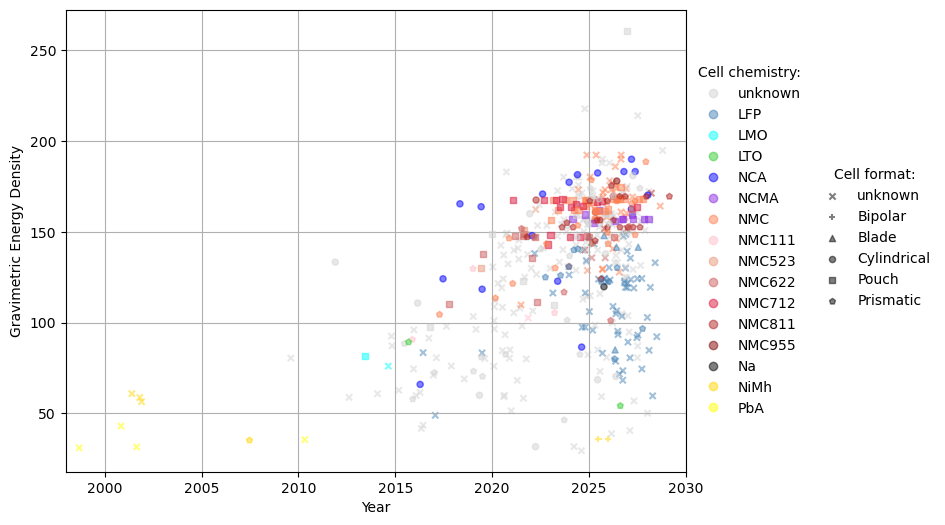

In [68]:
fig,ax=plt.subplots(figsize=(8,6))

cell_chem_codes = df.loc[subset_index,('Cell','Chemistry')].astype('category').cat.codes
# have to loop
for k in range(*df.loc[subset_index,('Cell','Format')].unique().shape):
    X_k = X[df.loc[subset_index,('Cell','Format')].astype('category').cat.codes == k-1]
    y_k = y[df.loc[subset_index,('Cell','Format')].astype('category').cat.codes == k-1]
    c_k = cell_chem_codes[df.loc[subset_index,('Cell','Format')].astype('category').cat.codes == k-1]
    scttr = ax.scatter(X_k,y_k,
                s=20.0,
                c=c_k,cmap=cell_chem_cmap,
                marker=cell_format_shape[k],
                alpha=0.5,
                zorder=k*20,
                vmin=-1,
                vmax=cell_chem_cmap.N-1,
                )

ax.set_xlabel('Year')
ax.set_xlim(1998,2030)
ax.set_ylabel(dependent_v[0])
ax.grid(True)
ax.set_axisbelow(True)

ax.legend(handles_0,np.concat((['unknown'],df.loc[subset_index,('Cell','Chemistry')].astype('category').cat.categories.values)),
           loc='center left', bbox_to_anchor=(1.0,0.5), title='Cell chemistry:', frameon=False)

fig.legend(handles_1,cell_format_labels,
           loc='center left', bbox_to_anchor=(1.05,0.5), title='Cell format:', frameon=False)
